# Predicting Customer Churn with Gradient Boosting Machine

In this article, we will predict customer churn using Gradient Boosting Machine GBM. 

To briefly introduce GBM, let's introduce the feature of GBM by comparing with Random Forest (RF).

1. Both RF and GBM are tree-based algorithms and they both make multiple trees (in R, default number of trees for RF is 500) to reach a decision

2. In RF, every tree is made independently; however, with GBM, each tree grows sequentially, meaning that the order matters and each tree is dependent on the previous tree (the 'weak learner'), specifically the residuals

3. In RF, every tree weights the same, meaning each tree has the same amount of say; in contrast, GBM assigns each tree with different weight, or the 'learning rate'; GBM increases the weight of incorrectly classified sample and decreases the weight of correctly classified sample

4. GBM allows user-defined loss function, which it uses to optimise (minimize) when growing each tree

Most important thing to remember that GBM grows trees sequentially and each tree is grown to improve the previous tree, particulary to minimize the residuals. The 'learning rate' is an important parameter here. It's adviced  to set the learning rate small, i.e. to take many small steps to get to the desired prediction.

## 1. Load Data

First, let's load the data from [Kaggle](https://www.kaggle.com/c/customer-churn-prediction-2020/overview) challenge.

Data cleaning, feature engineering and feature selection has already been processed and can be found [here](https://github.com/suranne-yujun-pan/predicting_churn/blob/master/Predicting_Customer_Churn_Random_Forest.ipynb) in the previous article.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("/Users/panyujun/Documents/Portfolio/customer_churn/data/cleaned/train.csv")
test = pd.read_csv("/Users/panyujun/Documents/Portfolio/customer_churn/data/cleaned/test.csv")

In [3]:
train['churn'] = train['churn'].replace({'no':0, 'yes':1})

## 2. Train GBM Model

### 2.1 Split data into training and test set

Split the dataset into training and test set using the 80/20 rule.

In [39]:
from sklearn.model_selection import train_test_split

X = train.drop('churn', axis=1)
y = train['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

Now let's initialize the GBM classifier and take a look at the hyperparameters and its values.

In [52]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(random_state=2)
clf.fit(X_train, y_train)

GradientBoostingRegressor(random_state=2)

In [7]:
clf.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 1,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

We will come back to these values when tuning the hyperparameters later.

### 2.2 Evaluating the Model Performance

For now, let's focus on the performance of the classifier:

#### Precision:

In [53]:
clf.score(X_test, y_test)

0.6973373393179885

This is a rather low precision. However, be mindful that the default number of trees here is 100 and the learning rate is 0.1. Usually, the default value for `n_estimators` is 500. We will come back to this later when tuning the hyperparameters.

#### Recall or sensitivity:

The calculation of sensitivity is a bit tricky here, since we are transforming predicted probailities to binary encoding.

Let's first recode the churn variable to 0 and 1, using 0.5 as threshold.

In [75]:
from sklearn.metrics import recall_score
y_pred = clf.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

In [76]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred, labels=[0,1]))

[[716   5]
 [ 31  98]]


The sensitivity calculated from confusion matrix is:

In [56]:
98/(31+98)

0.7596899224806202

Or we can use the `recall_score` function:

In [77]:
recall_score(y_test, y_pred)

0.7596899224806202

#### F1 score:

In [78]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.8448275862068966

### 2.3 Tuning Hyperparameters

First, let's define the possible values of hyperparameters in GBM. A lot of these hyperparameters should look familiar in Random Forest. Below is a list of the hyperparameters we are going to define in the tuning process.

* `n_estimators`: Number of trees

* `learning_rate`: Values that shrinks the contribution of each tree

* `max_depth`: Max depth of trees

* `max_features`: Number of features for best split

* `min_sample_splits`: Minimum samples to split node

* `min_samples_leaf`: Minimum samples in each leaf node

First let's define a parameters grid with possible values for each hyperparameter:

In [112]:
param_grid = {"n_estimators": [100, 200, 300, 400, 500, 600],
              'learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1],
              "max_depth": [3, None],
              "max_features": ['auto', 'sqrt', 'log2', None],
              "min_samples_split": [20, 40, 50],
             "min_samples_leaf": [1,5,10,20]}

After defining the hyperparameter grid, the most conventional thing to do would be going through each combination of the hyperparameters and test the model performance. However, given the large number of hyperparameters here, I've decided to do a random search. Instead of going through every combination, random search randomly select each observation in the parameters grid dataset and pick the one with the best performance, which is less computing expensive compared to grid search.

The code should look very similar to `GridSearchCV`

In [113]:
from sklearn.model_selection import RandomizedSearchCV

In [114]:
random_search = RandomizedSearchCV(clf, param_grid)

In [115]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=2),
                   param_distributions={'learning_rate': [0.01, 0.03, 0.05,
                                                          0.08, 0.1],
                                        'max_depth': [3, None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 5, 10, 20],
                                        'min_samples_split': [20, 40, 50],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600]})

Let's take a look at the hyperparameters of the chosen model:

In [116]:
random_search.best_params_

{'n_estimators': 200,
 'min_samples_split': 40,
 'min_samples_leaf': 20,
 'max_features': None,
 'max_depth': 3,
 'learning_rate': 0.1}

It's time to feed these parameters into the model:

In [117]:
clf_opt = ensemble.GradientBoostingRegressor(random_state=142,
                                        n_estimators = 200,
                                        min_samples_split = 40,
                                        min_samples_leaf = 20,
                                        max_features = None,
                                        max_depth = 3,
                                        learning_rate = 0.1)
clf_opt.fit(X_train, y_train)

GradientBoostingRegressor(min_samples_leaf=20, min_samples_split=40,
                          n_estimators=200, random_state=142)

In [118]:
clf_opt.score(X_test, y_test)

0.6996044711225413

We can see that the new model did not improve significantly compared to previous model. It's hard to make a decision at the moment. We will continue to do some digging and make final decision.

## 3. Model Comparison

In [119]:
y_pred_opt = clf_opt.predict(X_test)
y_pred_opt = np.where(y_pred_opt > 0.5, 1, 0)

In [122]:
pd.DataFrame({'precision': [clf.score(X_test, y_test), clf_opt.score(X_test, y_test)],
'recall': [recall_score(y_test, y_pred), recall_score(y_test, y_pred_opt)],
'f1':[f1_score(y_test, y_pred), f1_score(y_test, y_pred_opt)]},
             index = ['original', 'random_search'])

,precision,recall,f1
original,0.697337,0.75969,0.844828
random_search,0.699604,0.75969,0.841202


We can see from the metrics that the model selected by random search performs slightly better. 

In [130]:
from sklearn.metrics import roc_curve

# original model
y_pred = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [131]:
# model selected by grid search
y_pred_opt = clf_opt.predict(X_test)
fpr_opt, tpr_opt, thresholds_opt = roc_curve(y_test, y_pred_opt)

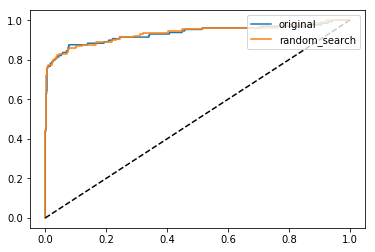

In [133]:
plt.plot(fpr, tpr, label = 'original')
plt.plot(fpr_opt, tpr_opt, label = 'random_search')
plt.plot([0, 1], [0, 1], "k--")

plt.legend(loc="upper right")
plt.show()

In [135]:
from sklearn.metrics import roc_auc_score
[roc_auc_score(y_test, y_pred), roc_auc_score(y_test, y_pred_opt)]

[0.9324689008590566, 0.9346837402831983]

Therefore, we will choose the model selected by random search as our final predicting model.